![title](https://i.ibb.co/f2W87Fg/logo2020.png)

---


<table  class="tfo-notebook-buttons" align="left"><tr><td>
    
<a href="https://colab.research.google.com/github/adf-telkomuniv/CV2020_Exercises/blob/main/CV2020 - 12.2 - Network Visualization (TensorFlow).ipynb" source="blank" ><img src="https://colab.research.google.com/assets/colab-badge.svg"></a>
</td><td>
<a href="https://github.com/adf-telkomuniv/CV2020_Exercises/blob/main/CV2020 - 12.2 - Network Visualization (TensorFlow).ipynb" source="blank" ><img src="https://i.ibb.co/6NxqGSF/pinpng-com-github-logo-png-small.png"></a>
    
</td></tr></table>

# Task 12 part 2 - Network Visualization (TensorFlow)

A convolutional neural network typically has multiple convolutional layers (hence, the name).

Conceptually, we understand each convolutional layer extracts spatial features from their inputs.  Earlier layer detects low-level features like color, texture, lines, curves, etc.  Later layers detect higher abstraction like eyes, tail, etc.


In this notebook, we use a pre-trained convolutional neural network to see what kind of input images strongly activate filters in convolutional layers.

This notebook code is largely based on the blog article **How convolutional neural networks see the world** by **Francois Chollet** [2].

Write down your Name and Student ID

In [1]:
## --- start your code here ----

NIM  = 1301170073
Nama = "Pratama Yoga Santosa"

## --- end your code here ----

---
---
#[Part 0] Import Libraries 

In [2]:
import numpy as np
import scipy
import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline

---
---
# [Part 1] Load Pretrained Model

We could use any other convolutional neural network, but here we use the pre-trained VGG16 available in Keras.  


---
## 1 - Load VGG16 Model
The following shows the available convolutional layers in VGG16.

In [3]:
from tensorflow.keras import Model
from tensorflow.keras.applications.vgg16 import VGG16

vgg_model = VGG16(weights='imagenet', include_top=False)
vgg_model.summary()

58892288/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
______________________________________________________________

---
## 2 - Helper Function


Typically, the input to the VGG16 model is an image to classify such as cats and dogs. 

Here, however, we use a randomly generated noise image and feed it to VGG16 model to calculate filter activations and their gradients.

---
### a. Random Image Generator

We start the visualization from a random image

In [4]:
def make_random_image(img_height=128, img_width=128, shift=True):
    img = tf.random.uniform((1, img_width, img_height, 3))
    if shift:
        return (img - 0.5) * 0.25
    return img * 0.25

---
### b. Convert to Image

Function to convert result data into 0-255 image data

In [5]:
def convert_to_image(x):
    # normalize data
    # set the std to 0.1 and the mean to 0.5
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.15
    
    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)
    
    # convert to RGB array
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

let's try to visualize a random image patch

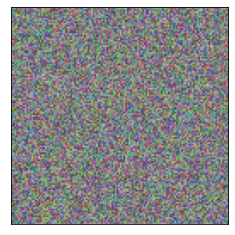

In [6]:
input_img = make_random_image()

img = convert_to_image(input_img[0].numpy())
plt.imshow(img)
plt.xticks([])
plt.yticks([])
plt.show()

---
---

# [Part 2] Filter Visualization

Filter Visualization is basically performing a Gradient Ascent into an input image to maximize the filter activation. Gradient ascent function simply computes the gradients of the loss above with regard to the input image, and update the update image so as to move it towards a state that will activate the target filter more strongly.

In TensorFlow 2, we use GradientTape to perform backward pass. GradientTape is an API for automatic differentiation; that is, computing the gradient of a computation with respect to some inputs. TensorFlow then uses that tape to compute the gradients of a "recorded" computation using reverse mode differentiation.

And with Eager execution, it is faster to compute the gradient by constructing a callable function that executes a TensorFlow graph by defining a `@tf.function`.

So let's do that


---
## 1 - Gradient Ascent Function

Here we define a `@tf.function` to perform Gradient Ascent



---
#### <font color='red'>**EXERCISE:** </font>

Implement this function. 
* Perform gradient ascent to generate filter visualization


In [7]:
@tf.function
def gradient_ascent_filter(img, filter_index, step_size, model):
    with tf.GradientTape() as tape:
        tape.watch(img)

        # get activation from model
        # call model() with input img
        activation = model(img)

        # We avoid border artifacts by only involving non-border pixels in the loss.
        filter_activation = activation[:, 2:-2, 2:-2, filter_index]

        # calculate the loss from activation
        # call tf.reduce_mean() function with input filter_activation
        loss = tf.reduce_mean(filter_activation)

    # Compute gradients.
    # call tape.gradient() with input loss and img
    grads = tape.gradient(loss, img) 

    # Normalize gradients.
    grads = tf.math.l2_normalize(grads)
    img += step_size * grads

    return img


---
## 2 - Visualization Function
Now define a function to perform the filter visualization loop end-to-end. 
We start from a random image that is close to "all gray" (i.e. visually netural), then repeatedly apply the gradient ascent step function defined above. 

Lastly, we convert the resulting input image back to a displayable form, by normalizing it and restricting it to the [0, 255] range.



---
#### <font color='red'>**EXERCISE:** </font>

Implement this function. 
* Perform gradient ascent to generate filter visualization


In [8]:
def visualize_filter(model, input_img, layer_name, filter_index, steps=50, step_size=10.0 ):

    img = input_img

    # get layer from model based on layer_name 
    # by calling model.get_layer() function with input layer_name
    layer = model.get_layer(layer_name)

    # Set up a model that returns the activation values for our target layer
    feature_extractor = Model(inputs=model.inputs, outputs=layer.output)

    # perform gradient ascent
    for iteration in range(steps):
        # call gradient_ascent_filter() function with input img, filter_index, 
        # step_size, and feature_extractor
        img = gradient_ascent_filter(img, filter_index, step_size, feature_extractor)

    # Decode the resulting input image
    img = convert_to_image(img[0].numpy())
    
    return img

---
## 3 - Visualize a Filter

The following is an example of an input image that strongly activates the first filter in the layer `block4_conv1`.

You can change the `layer_name` and `filter_index`


In [9]:
layer_name   = 'block4_conv1'         # change this to see filter from another layer
filter_index = 0
input_img    = make_random_image()

result = visualize_filter(vgg_model, input_img, layer_name, filter_index)


Visualize the filter

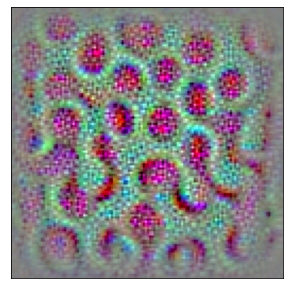

In [10]:
plt.figure(figsize=(15,5))
plt.imshow(result)
plt.xticks([])
plt.yticks([])
plt.show()

---
## 4 - Visualize 20 Filters
Let's examine some filters in a layer. In the function below, we're going to select 20 filters randomly, and view it's visualization

In [11]:
def visualize_20_filters(model, layer_name, steps=80, step_size=10.0, shift=True):
  
    input_img = make_random_image(shift=shift)
    print('Showing 20 random filters for layer', layer_name)
    plt.figure(figsize=(16,16))
    num_filter = model.get_layer(layer_name).output.shape[3]

    for i in range(20):
        idx = np.random.randint(0,num_filter)
        result = visualize_filter(model, input_img, layer_name, filter_index=idx, steps=steps, step_size=step_size)    
        plt.subplot(4, 5, i+1)
        plt.imshow(result)
        plt.gca().set_title(idx)
        plt.xticks([])
        plt.yticks([])
        
    plt.tight_layout()
    plt.show()

Visualize the filter

Showing 20 random filters for layer block3_conv3


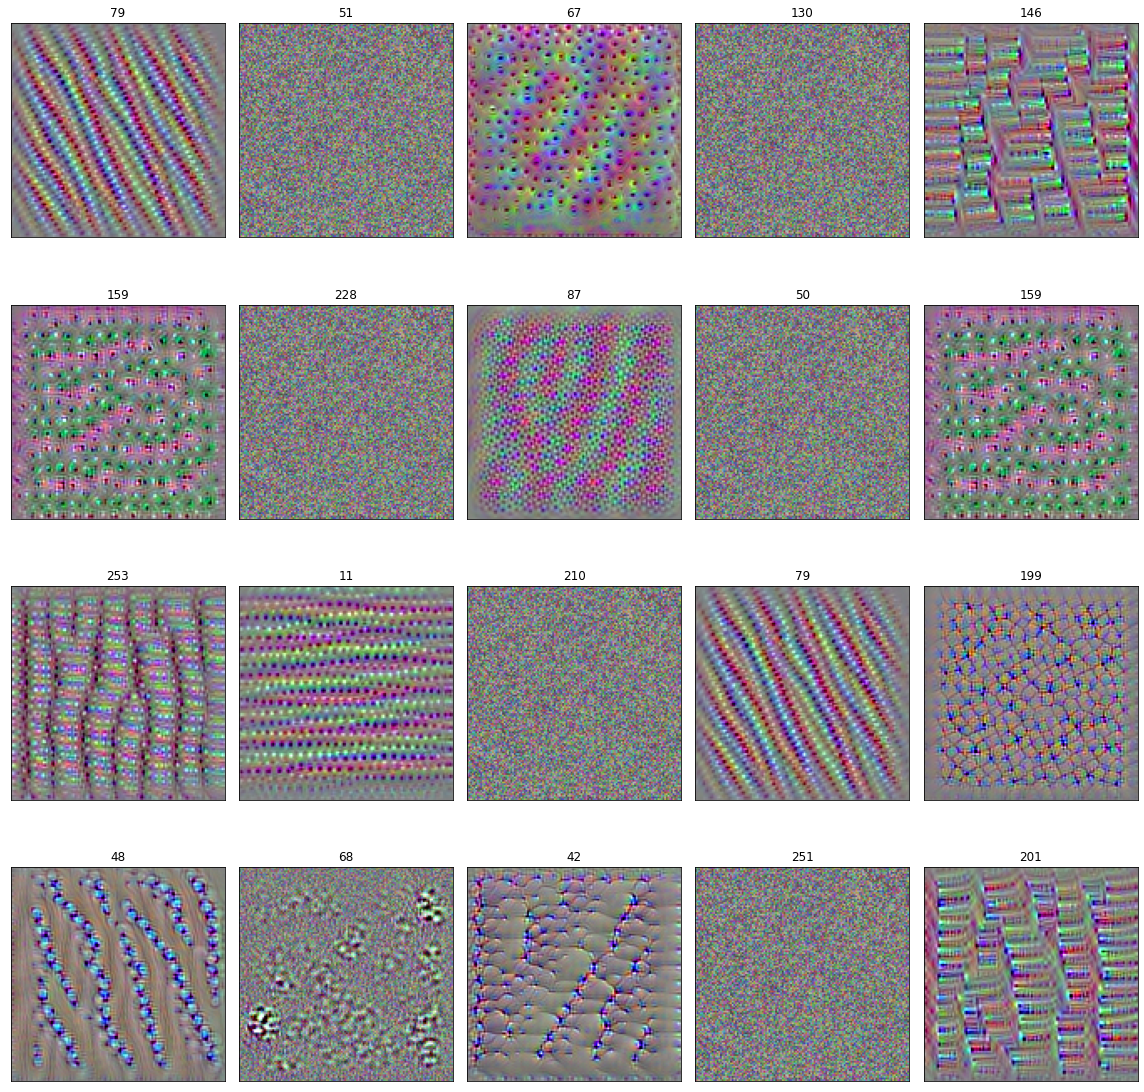

In [12]:
layer_name   = 'block3_conv3'        # change this to see filter from another layer

visualize_20_filters(vgg_model, layer_name, steps=80)

---
---
# [Part 3] VGG Face Visualization

Now for comparison, Here you are provided a vgg model that has been trained on face dataset.

The model was trained to perform various task from face detection to face recognition

So it made sense that the filters will form facial attributes

---
## 1 - Load VGG Face

Download and load the model provided



In [13]:
!wget -O 'vgg_face_notop.h5' 'https://github.com/CNN-ADF/Task2019/raw/master/resources/vgg_face_notop.h5' -q

In [14]:
from tensorflow.keras.models import load_model

face_model = load_model('vgg_face_notop.h5')

face_model.summary()


Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

---
## 2 - Visualize 20 Filters
Let's examine some filters in a layer. In the function below, we're going to select 20 filters randomly, and view it's visualization

WARNING,<br>
you might see some disturbing features 	(￣ヘ￣)

Showing 20 random filters for layer block5_conv2


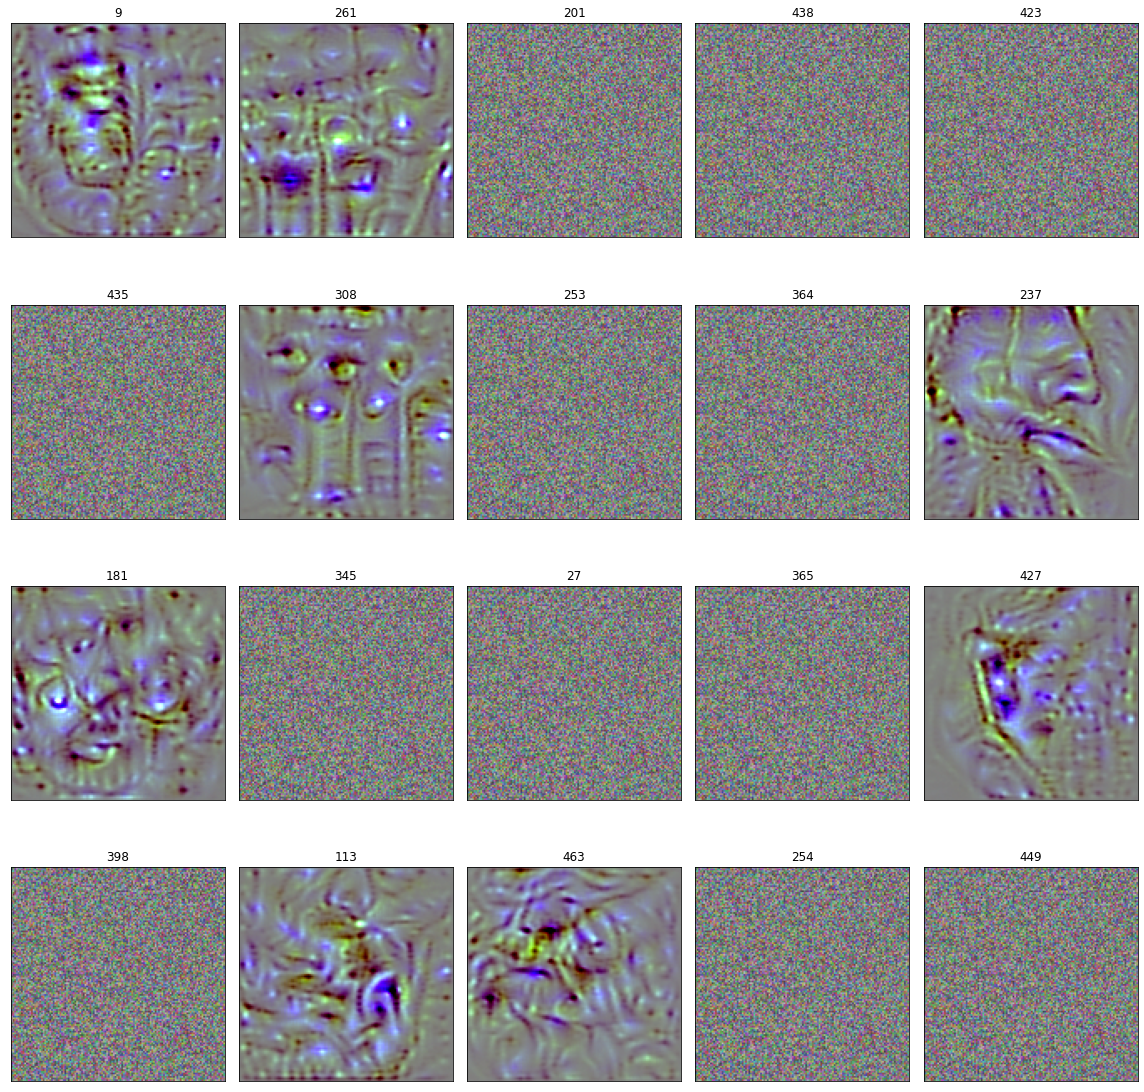

In [15]:
layer_name   = 'block5_conv2'        # change this to see filter from another layer

visualize_20_filters(face_model, layer_name, steps=100, step_size=10.0, shift=False)

---
---
# [Part 4] Little Deep Dreams

If we throw a Sky image into this experiment and let a filter to nudge the image, what do we get?

This is a similar idea used in **Inceptionism: Going Deeper into Neural Networks** [3].

---
## 1 - Load Image

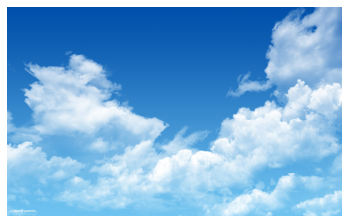

In [16]:
!wget -O 'sky1024px.jpg' 'https://images.squarespace-cdn.com/content/57c8515459cc68fba78d9781/1494175003092-5PQRBFQHQ31HXEWW9O07/sky1024px.jpg' -q

sky_img = plt.imread('sky1024px.jpg') 
plt.imshow(sky_img)
plt.axis('off')
plt.show()

---
## 2 - Hallucinate the Image

Now we perform the filter visualization to the image.

It will, in sense, hallucinate the appearance of the selected filters inside the image

In [17]:
layer_name   = 'block5_conv2'      # change this to hallucinate image using filter from another layer
filter_index = 15                  # change this to hallucinate image using another filter index
img = np.expand_dims(sky_img/127,0).astype('float')

result = visualize_filter(vgg_model, 
                         layer_name=layer_name,
                         filter_index=filter_index, 
                         input_img=img, 
                         steps=100)


Visualize the result

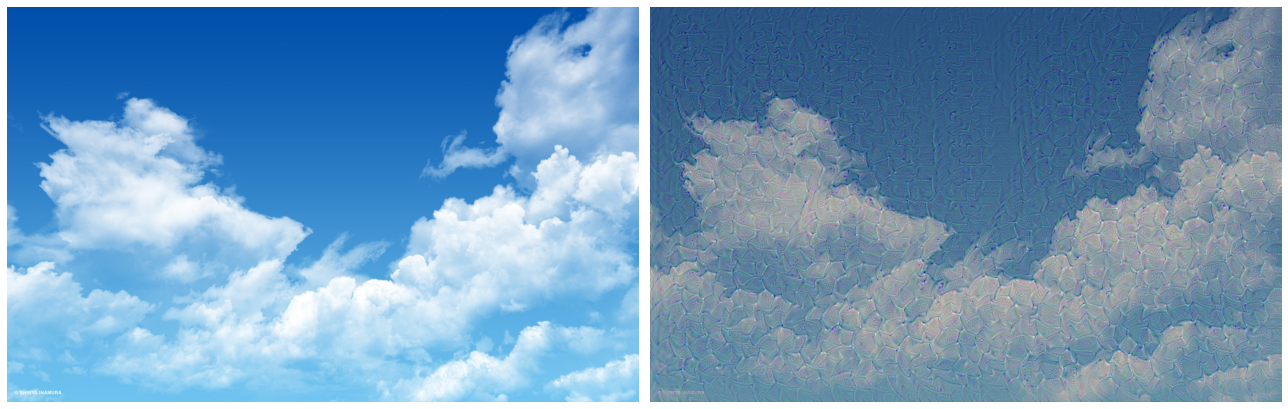

In [18]:
plt.figure(figsize=(18,8))
plt.subplot(121)
plt.imshow(sky_img)
plt.axis('off')
plt.subplot(122)
plt.imshow(result)
plt.axis('off')
plt.tight_layout()
plt.show()

And this is the process that was called Deep Dream

---
## 3 - Hallucinate using VGG Face

Now let's try to hallucinate the image using VGG Face Model

In [19]:
layer_name   = 'block5_conv2'      # change this to hallucinate image using filter from another layer
filter_index = 153                 # change this to hallucinate image using another filter index

result = visualize_filter(face_model, 
                         layer_name=layer_name,
                         filter_index=filter_index, 
                         input_img=img, 
                         steps=100)


Visualize the result

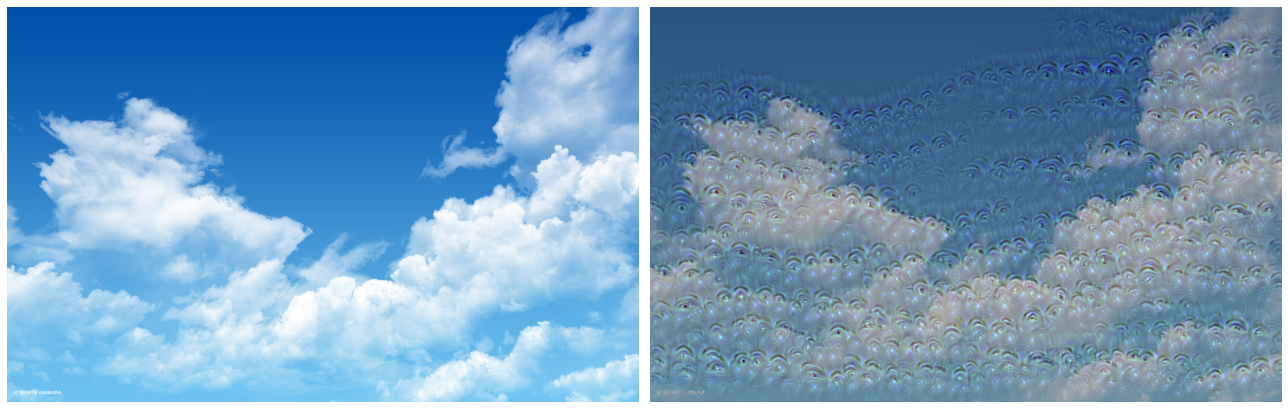

In [20]:
plt.figure(figsize=(18,8))
plt.subplot(121)
plt.imshow(sky_img)
plt.axis('off')
plt.subplot(122)
plt.imshow(result)
plt.axis('off')
plt.tight_layout()
plt.show()

You can see that now there're face feature (the one that you selected) everywhere on the image.

Now let's try to build a better Deep Dream function that produce better image.

---
---
# [Part 4] Deep Dreams using Inception V3

"Deep dream" is an image-filtering technique which consists of taking an image classification model, and running gradient ascent over an input image to try to maximize the activations of specific layers (and sometimes, specific units in specific layers) for this input. It produces hallucination-like visuals.

It was first introduced by Alexander Mordvintsev from Google in July 2015.

To build a better Deep Dream Image, let's use `InceptionV3` model for this exercise


---
## 1 - Load Inception Model

Here we load InceptionV3 model that was trained on Imagenet

In [21]:
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, save_img, img_to_array

inception_model = InceptionV3(weights='imagenet',include_top=False)

# model.summary()

87916544/87910968 [==============================] - 0s 0us/step


---
## 2 - Helper Function
Notice that using previous helper function, the image result became darker

To clear the image, we prepare another helper function


In [22]:
def preprocess_image(image_path):
    # Util function to open, resize and format pictures into appropriate tensors.
    img = load_img(image_path)
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    return img

def deprocess_image(x):
    # reshape array into a valid image
    x = x.reshape((x.shape[1], x.shape[2], 3))

    # Undo inception v3 preprocessing
    x /= 2.
    x += 0.5
    x *= 255.

    # Convert to uint8 and clip to the valid range [0, 255]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

---
## 3 - Gradient Ascent Function

Similar to before, here we define a `@tf.function` to perform Gradient Ascent. However, slightly different from before, in Gradient Ascent for Deep Dream, we calculate the loss from activations of several layers that we choose, scaled by its coefficient that we also defined.



---
#### <font color='red'>**EXERCISE:** </font>

Complete the function

In [23]:
@tf.function
def gradient_ascent_deep_dream(img, step_size, model):
    with tf.GradientTape() as tape:
        tape.watch(img)

        # get features from model
        # call model() with input img
        features = model(img)

        # Initialize the loss
        loss = tf.zeros(shape=())

        # extract activations from the selected features
        for name in features.keys():
            # get coefficient for features in each layer
            coeff = dream_filters[name]
            
            # get the activation
            activation = features[name]
            
            # We avoid border artifacts by only involving non-border pixels in the loss.
            scaling = tf.reduce_prod(tf.cast(tf.shape(activation), "float32"))

            # define loss function
            loss += coeff * tf.reduce_sum(tf.square(activation[:, 2:-2, 2:-2, :])) / scaling

    # Compute gradients.
    # call tape.gradient() with input loss and img
    grads = tape.gradient(loss, img)

    # Normalize gradients.
    grads /= tf.maximum(tf.reduce_mean(tf.abs(grads)), 1e-6)
    img += step_size * grads

    return img

---
## 3 - Deep Dream Function

The complete Deep Dream Function perform the filter hallucination in several image scales to generate better and more "smooth" image. 

The process is by defining the number of processing scales ("octaves"), then start hallucinating image from the smallest scale. 

For every scale, we resize the image to that scale, run gradient ascent, upscale image to the next scale, and reinject the detail that was lost at upscaling time.

We stop the process when we are back to the original size. To obtain the detail lost during upscaling, we simply take the original image, shrink it down, upscale it, and compare the result to the (resized) original image.

---
#### <font color='red'>**EXERCISE:** </font>

Complete this function. 


In [24]:
def deep_dream(model, input_img_path, dream_filters, num_octave, octave_scale, steps=20, step_size=0.01):

    # Get the symbolic outputs of each "key" layer (we gave them unique names).
    outputs_dict = dict([
        (layer.name, layer.output)
        for layer in [model.get_layer(name) for name in dream_filters.keys()]
    ])

    # Set up a model that returns the activation values for every target layer
    feature_extractor = Model(inputs=model.inputs, outputs=outputs_dict)

    # prepare original image
    original_img      = preprocess_image(input_img_path)
    original_shape    = original_img.shape[1:3]
    successive_shapes = [original_shape]

    for i in range(1, num_octave):
        shape = tuple([int(dim / (octave_scale ** i)) for dim in original_shape])
        successive_shapes.append(shape)
    successive_shapes = successive_shapes[::-1]
    shrunk_original_img = tf.image.resize(original_img, successive_shapes[0])

    # Make a copy of original image
    img = tf.identity(original_img)  

    # perform Deep Dream in multiple image scale
    for shape in successive_shapes:  
        print('Processing image shape', shape)

        # resize image by calling tf.image.resize() function 
        # with input img and shape
        img = tf.image.resize(img, shape)

        # perform gradient ascent
        for i in range(steps):
            # call gradient_ascent_deep_dream() function  
            # with input img, step_size, and feature_extractor
            img = gradient_ascent_deep_dream(img, step_size, feature_extractor)

        # resize back image
        upscaled_shrunk_original_img = tf.image.resize(shrunk_original_img, shape)
        same_size_original           = tf.image.resize(original_img, shape)
        lost_detail                  = same_size_original - upscaled_shrunk_original_img

        # hallucinate the image by adding the lost_detail to img
        img = img + lost_detail
        
        # resize original image by calling tf.image.resize() function 
        # with input original_img and shape
        shrunk_original_img = tf.image.resize(original_img, shape)

    # convert the result into image by calling deprocess_image() function with input img.numpy()
    image_result = deprocess_image(img.numpy())
    
    return image_result


---
## 4 - Feature List

Now, define list of filter that will be used to hallucinate the image

You can change or add the feature and coefficient to use. 

See the list of layer name in `summary()` method

In [25]:
dream_filters = {
    # 'mixed2' : 0.2,
    'mixed4' : 1.1,
    'mixed5' : 1.4,
    'mixed7' : 2.5,
    'mixed8' : 1.0,
}

---
## 5 - Perform Deep Dream

In [26]:
# prepare setting for scaling process
num_octave   = 5         # Number of scales at which to run gradient ascent
octave_scale = 1.5       # Size ratio between scales

result = deep_dream(inception_model, 'sky1024px.jpg', dream_filters, num_octave, octave_scale, steps=20)

Processing image shape (197, 316)
Processing image shape (296, 474)
Processing image shape (444, 711)
Processing image shape (666, 1066)
Processing image shape (1000, 1600)


Visualize the result

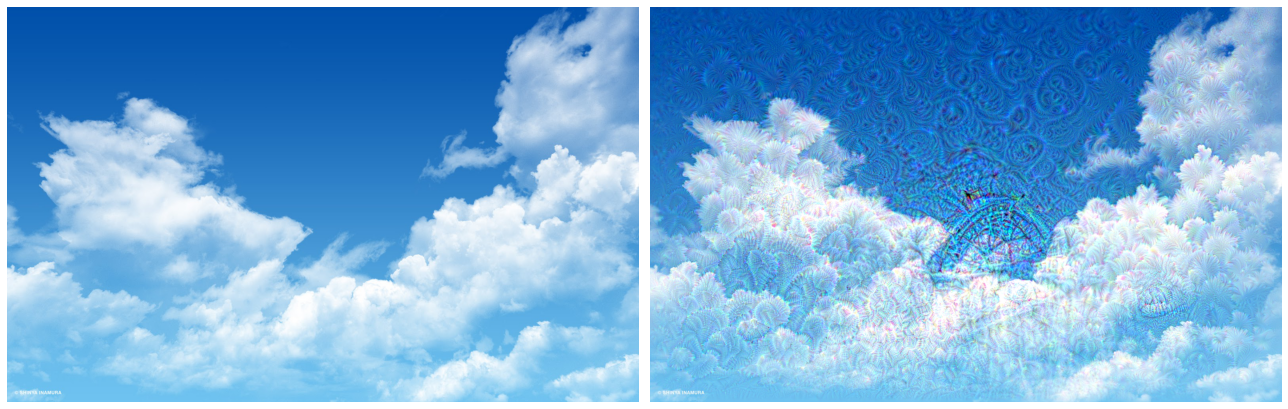

In [27]:
plt.figure(figsize=(18,8))
plt.subplot(121)
plt.imshow(sky_img)
plt.axis('off')

plt.subplot(122)
plt.imshow(result)
plt.axis('off')
plt.tight_layout()

plt.show()

---
---

# Congratulation, You've Completed Exercise 12 part 2

<p>Copyright &copy;  <a href=https://www.linkedin.com/in/andityaarifianto/>2020 - ADF</a> </p>

![footer](https://i.ibb.co/yX0jfMS/footer2020.png)